## Train models on the enhanced data (with all new columns)

In [1]:
import warnings

# from ml.labevents_enhanced_study import selected_features

warnings.filterwarnings("ignore")

In [2]:
import configparser
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../data_transformation/data_transfer"))

from utils import ConnectionDetails, DataTransfer

config = configparser.ConfigParser()
config.read('../config.ini')

print(*(x[1] for x in config.items('database')))

dt = DataTransfer(ConnectionDetails(*(x[1] for x in config.items('database'))))

sql_query = """
SELECT *
FROM mart.admissions
"""

df = dt.fetch_data(sql_query)

postgresql mimic-iv_db agabitas_non_su aGaBiTaS dws-login-01.informatik.uni-mannheim.de 5432


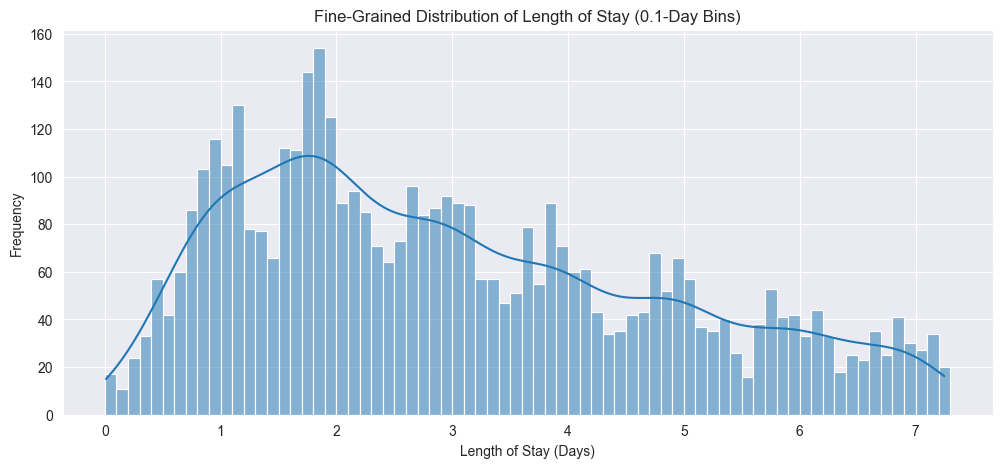

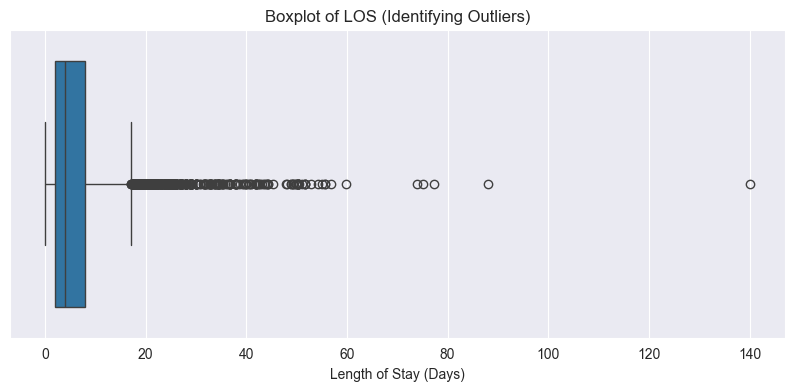

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define fine-grained bins (every 0.25 days)
df_to_vis = df[df["los"] <= 7.25]
max_los = df_to_vis["los"].max()
bins = np.arange(0, max_los + 0.10, 0.10)  # Step of 0.25 days

# Histogram with KDE
plt.figure(figsize=(12, 5))
sns.histplot(df_to_vis["los"], bins=bins, kde=True)
plt.xlabel("Length of Stay (Days)")
plt.ylabel("Frequency")
plt.title("Fine-Grained Distribution of Length of Stay (0.1-Day Bins)")
plt.show()

# Boxplot for LOS
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["los"])
plt.xlabel("Length of Stay (Days)")
plt.title("Boxplot of LOS (Identifying Outliers)")
plt.show()


In [3]:
df.head()

,subject_id,hadm_id,admittime,admit_daytime,admission_month,dischtime,deathtime,admission_type,admit_provider_id,admission_location,...,hematocrit_csf_max_value,hematocrit_csf_avg_value,hematocrit_csf_ref_range_lower,hematocrit_csf_ref_range_upper,hematocrit_csf_was_abnormal,hematocrit_csf_ratio_abnormal,hematocrit_csf_first_abnormal_charttime,hematocrit_csf_first_test_charttime,hematocrit_csf_last_test_charttime,hematocrit_csf_abnormal_hrs_until_discharge
0,10007785,22943998,2156-05-16 01:36:00,night,5.0,2156-05-21 17:10:00,NaT,EW EMER.,P15TKT,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
1,10004113,29879900,2173-03-20 00:00:00,night,3.0,2173-03-22 14:35:00,NaT,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
2,10010888,20162667,2174-01-09 22:19:00,night,1.0,2174-01-27 16:00:00,NaT,EW EMER.,P26WQF,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
3,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
4,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN


In [4]:
df = pd.get_dummies(df, columns=['admit_daytime'])

df = pd.get_dummies(df, columns=['marital_status'])

df = pd.get_dummies(df, columns=['race'])

df = pd.get_dummies(df, columns=['gender'])

df = pd.get_dummies(df, columns=['anchor_year_group'])

df['icd_code_numeric'] = df['icd_code'].replace({
    r'^I61.*': 'I61',   # Match codes starting with 'I61'
    r'^I63.*': 'I63',   # Match codes starting with 'I63'
    r'^G41.*': 'G41'    # Match codes starting with 'G41'
}, regex=True)

columns_to_drop = [column for column in df.columns if any(substring in column for substring in ['range', 'charttime', 'until_discharge'])]

<Axes: ylabel='Frequency'>

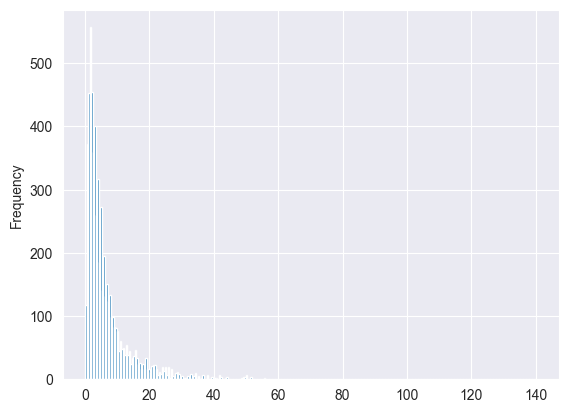

In [5]:
df['los'].plot.hist(bins=300)

In [6]:
def transform_los(los):
    if los <= 2:
        return 0
    elif 3 <= los <= 7:
        return 1
    else:
        return 2

df['los'] = df['los'].apply(transform_los)

In [7]:
df

,subject_id,hadm_id,admittime,admission_month,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,...,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,gender_F,gender_M,anchor_year_group_2008 - 2010,anchor_year_group_2011 - 2013,anchor_year_group_2014 - 2016,anchor_year_group_2017 - 2019,anchor_year_group_2020 - 2022,icd_code_numeric
0,10007785,22943998,2156-05-16 01:36:00,5.0,2156-05-21 17:10:00,NaT,EW EMER.,P15TKT,TRANSFER FROM HOSPITAL,HOME,...,False,False,False,True,False,False,False,False,True,I63
1,10004113,29879900,2173-03-20 00:00:00,3.0,2173-03-22 14:35:00,NaT,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,HOME,...,False,False,False,True,False,False,True,False,False,I61
2,10010888,20162667,2174-01-09 22:19:00,1.0,2174-01-27 16:00:00,NaT,EW EMER.,P26WQF,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,...,False,False,False,True,False,False,False,False,True,I63
3,10013310,22098926,2153-06-10 11:55:00,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,SKILLED NURSING FACILITY,...,False,False,True,False,False,False,False,True,False,I61
4,10013310,22098926,2153-06-10 11:55:00,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,SKILLED NURSING FACILITY,...,False,False,True,False,False,False,False,True,False,I63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6169,19985409,27293537,2154-09-21 20:49:00,9.0,2154-09-28 14:39:00,NaT,EW EMER.,P627AF,TRANSFER FROM HOSPITAL,CHRONIC/LONG TERM ACUTE CARE,...,False,False,False,True,False,False,False,True,False,I63
6170,19987702,26568899,2131-01-13 16:45:00,1.0,2131-01-23 15:00:00,NaT,OBSERVATION ADMIT,P468KA,TRANSFER FROM HOSPITAL,REHAB,...,False,False,False,True,False,False,False,True,False,I61
6171,19987702,26568899,2131-01-13 16:45:00,1.0,2131-01-23 15:00:00,NaT,OBSERVATION ADMIT,P468KA,TRANSFER FROM HOSPITAL,REHAB,...,False,False,False,True,False,False,False,True,False,I63
6172,19989126,21824927,2155-01-31 01:09:00,1.0,2155-02-03 15:47:00,NaT,URGENT,P64UQ5,TRANSFER FROM HOSPITAL,HOME,...,False,False,True,False,True,False,False,False,False,I61


In [8]:
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, KFold


cur_df = df.copy()
X = cur_df.drop('los', axis=1)
y = cur_df['los']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


encoder = ce.BinaryEncoder(cols = [
    'first_careunit', 
    'last_careunit', 
    'admission_type',
    'admission_location',
    'discharge_location',
    'insurance',
    'language',
    'icd_code_numeric'
] , return_df = True)

encoder.fit(X_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [9]:
X_train.drop(columns=[
    'dod',
    'icd_code',
    'icd_version',
    'stay_id',
    'admit_provider_id',
    'subject_id',
    'hadm_id',

    #timestamp columns
    'intime',
    'outtime',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    *columns_to_drop
], inplace=True, axis=1)

X_test.drop(columns=[
    'dod',
    'icd_code',
    'icd_version',
    'stay_id',
    'admit_provider_id',
    'subject_id',
    'hadm_id',
    
    #timestamp columns
    'intime',
    'outtime',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    *columns_to_drop
], inplace=True, axis=1)

In [10]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [11]:
def fillna_tests(test_name: str, df: pd.DataFrame):
    df[f'{test_name}_min_value'].fillna(-1, inplace=True)
    df[f'{test_name}_max_value'].fillna(-1, inplace=True)
    df[f'{test_name}_avg_value'].fillna(-1, inplace=True)
    df[f'{test_name}_was_abnormal'].fillna(False, inplace=True)
    df[f'{test_name}_ratio_abnormal'].fillna(0, inplace=True)
    # df[f'{test_name}_abnormal_hrs_until_discharge'].fillna(-1, inplace=True)

In [12]:
tests = [
    'sodium',
    'sodium_urine',
    'sodium_whole_blood',
    'potassium',
    'potassium_whole_blood',
    'calcium_total',
    'free_calcium',
    'magnesium',
    'glucose',
    'glucose_ascites',
    'glucose_body_fluid', 
    'glucose_csf',
    'lactate',
    'lactate_dehydrogenase_csf',
    'lactate_dehydrogenase_ld',
    'ph',
    'po2',
    'bicarbonate',
    'bicarbonate_urine',
    'calculated_bicarbonate_whole_blood',
    'inr_pt',
    'pt',
    'ptt',
    'crp',
    'white_blood_cells',
    'ammonia',
    'albumin',
    'albumin_creatine_urine',
    'creatinine',
    'creatinine_clearance',
    'creatinine_serum',
    'urea_nitrogen',
    'alt',
    'ast',
    'bilirubin',
    'bilirubin_direct',
    'bilirubin_indirect',
    'bilirubin_total',
    'ratio_hemoglobin_a1c',
    'hemoglobin',
    'hematocrit',
    'hematocrit_csf'
]

In [13]:
for test in tests:
    fillna_tests(test, X_train)
    fillna_tests(test, X_test)

In [14]:
print(X_train.columns[X_train.isnull().sum() > 0])

Index([], dtype='object')


In [15]:
print(X_test.columns[X_test.isnull().sum() > 0])

Index([], dtype='object')


<Axes: >

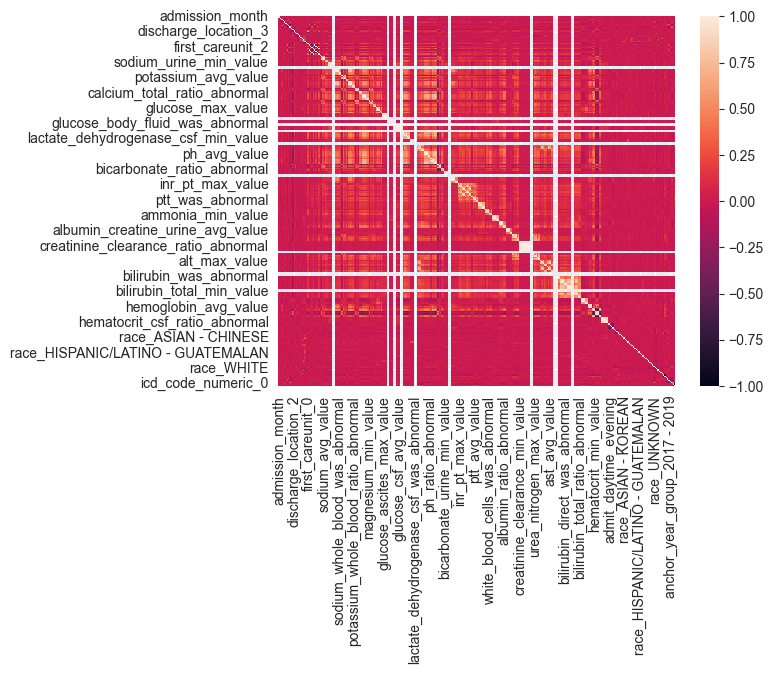

In [16]:
import seaborn as sns
%matplotlib inline

corr = X_train.corr()

sns.heatmap(corr)

In [17]:
X_train.corrwith(y_train).sort_values(ascending=False).head(21)

ph_max_value                      0.281210
ph_avg_value                      0.274906
ph_min_value                      0.267647
sodium_was_abnormal               0.243862
free_calcium_max_value            0.240445
free_calcium_avg_value            0.235015
calcium_total_was_abnormal        0.229900
po2_was_abnormal                  0.228350
free_calcium_min_value            0.228157
ph_was_abnormal                   0.224149
po2_max_value                     0.220395
bicarbonate_max_value             0.213009
white_blood_cells_was_abnormal    0.206662
free_calcium_was_abnormal         0.204822
potassium_was_abnormal            0.201540
glucose_ratio_abnormal            0.198804
bicarbonate_was_abnormal          0.195258
hematocrit_was_abnormal           0.194590
po2_ratio_abnormal                0.190323
urea_nitrogen_was_abnormal        0.188842
sodium_max_value                  0.188647
dtype: float64

In [18]:
from ml_utils import learn_models

In [19]:
X_train.head()

,admission_month,admission_type_0,admission_type_1,admission_type_2,admission_type_3,admission_location_0,admission_location_1,admission_location_2,admission_location_3,discharge_location_0,discharge_location_1,discharge_location_2,discharge_location_3,insurance_0,insurance_1,insurance_2,language_0,language_1,language_2,language_3,language_4,hospital_expire_flag,first_careunit_0,first_careunit_1,first_careunit_2,first_careunit_3,last_careunit_0,last_careunit_1,last_careunit_2,last_careunit_3,anchor_year,sodium_min_value,sodium_max_value,sodium_avg_value,sodium_was_abnormal,sodium_ratio_abnormal,sodium_urine_min_value,sodium_urine_max_value,sodium_urine_avg_value,sodium_urine_was_abnormal,sodium_urine_ratio_abnormal,sodium_whole_blood_min_value,sodium_whole_blood_max_value,sodium_whole_blood_avg_value,sodium_whole_blood_was_abnormal,sodium_whole_blood_ratio_abnormal,potassium_min_value,potassium_max_value,potassium_avg_value,potassium_was_abnormal,potassium_ratio_abnormal,potassium_whole_blood_min_value,potassium_whole_blood_max_value,potassium_whole_blood_avg_value,potassium_whole_blood_was_abnormal,potassium_whole_blood_ratio_abnormal,calcium_total_min_value,calcium_total_max_value,calcium_total_avg_value,calcium_total_was_abnormal,calcium_total_ratio_abnormal,free_calcium_min_value,free_calcium_max_value,free_calcium_avg_value,free_calcium_was_abnormal,free_calcium_ratio_abnormal,magnesium_min_value,magnesium_max_value,magnesium_avg_value,magnesium_was_abnormal,magnesium_ratio_abnormal,glucose_min_value,glucose_max_value,glucose_avg_value,glucose_was_abnormal,glucose_ratio_abnormal,glucose_ascites_min_value,glucose_ascites_max_value,glucose_ascites_avg_value,glucose_ascites_was_abnormal,glucose_ascites_ratio_abnormal,glucose_body_fluid_min_value,glucose_body_fluid_max_value,glucose_body_fluid_avg_value,glucose_body_fluid_was_abnormal,glucose_body_fluid_ratio_abnormal,glucose_csf_min_value,glucose_csf_max_value,glucose_csf_avg_value,glucose_csf_was_abnormal,glucose_csf_ratio_abnormal,lactate_min_value,lactate_max_value,lactate_avg_value,lactate_was_abnormal,lactate_ratio_abnormal,lactate_dehydrogenase_csf_min_value,lactate_dehydrogenase_csf_max_value,lactate_dehydrogenase_csf_avg_value,lactate_dehydrogenase_csf_was_abnormal,lactate_dehydrogenase_csf_ratio_abnormal,lactate_dehydrogenase_ld_min_value,lactate_dehydrogenase_ld_max_value,lactate_dehydrogenase_ld_avg_value,lactate_dehydrogenase_ld_was_abnormal,lactate_dehydrogenase_ld_ratio_abnormal,ph_min_value,ph_max_value,ph_avg_value,ph_was_abnormal,ph_ratio_abnormal,po2_min_value,po2_max_value,po2_avg_value,po2_was_abnormal,po2_ratio_abnormal,bicarbonate_min_value,bicarbonate_max_value,bicarbonate_avg_value,bicarbonate_was_abnormal,bicarbonate_ratio_abnormal,bicarbonate_urine_min_value,bicarbonate_urine_max_value,bicarbonate_urine_avg_value,bicarbonate_urine_was_abnormal,bicarbonate_urine_ratio_abnormal,calculated_bicarbonate_whole_blood_min_value,calculated_bicarbonate_whole_blood_max_value,calculated_bicarbonate_whole_blood_avg_value,calculated_bicarbonate_whole_blood_was_abnormal,calculated_bicarbonate_whole_blood_ratio_abnormal,inr_pt_min_value,inr_pt_max_value,inr_pt_avg_value,inr_pt_was_abnormal,inr_pt_ratio_abnormal,pt_min_value,pt_max_value,pt_avg_value,pt_was_abnormal,pt_ratio_abnormal,ptt_min_value,ptt_max_value,ptt_avg_value,ptt_was_abnormal,ptt_ratio_abnormal,crp_min_value,crp_max_value,crp_avg_value,crp_was_abnormal,crp_ratio_abnormal,white_blood_cells_min_value,white_blood_cells_max_value,white_blood_cells_avg_value,white_blood_cells_was_abnormal,white_blood_cells_ratio_abnormal,ammonia_min_value,ammonia_max_value,ammonia_avg_value,ammonia_was_abnormal,ammonia_ratio_abnormal,albumin_min_value,albumin_max_value,albumin_avg_value,albumin_was_abnormal,albumin_ratio_abnormal,albumin_creatine_urine_min_value,albumin_creatine_urine_max_value,albumin_creatine_urine_avg_value,albumin_creatine_urine_was_abnormal,albumin_creatine_urine_ratio_abnormal,creatinine_min_value,c

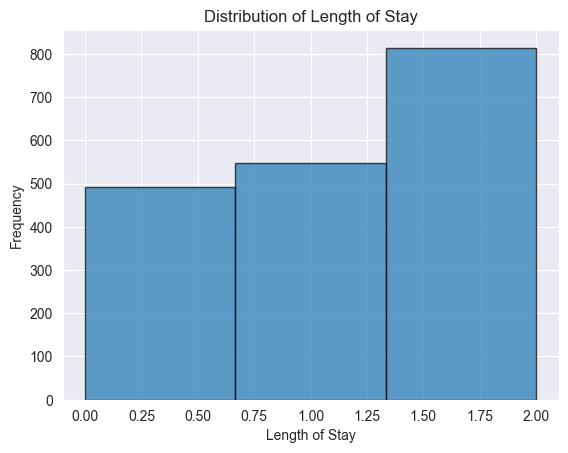

In [20]:
import matplotlib.pyplot as plt

plt.hist(y_test, bins=3, edgecolor='k', alpha=0.7)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.show()

In [21]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

initial_results = learn_models(
    models={
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(
            n_estimators=100, 
            max_depth=5, 
            random_state=42, 
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=100, 
            max_depth=5, 
            learning_rate=0.1, 
            objective='reg:squarederror', 
            random_state=42,
            enable_categorical=True,
        ),
        'CatBoost': CatBoostClassifier(
            iterations=100, 
            depth=5, 
            learning_rate=0.1,
            loss_function='MultiClass',
            eval_metric='Accuracy',
            random_seed=42,
            verbose=False
        ),
        'SVM': SVC(
            kernel='linear',
            C=0.104,
            probability=True,
            random_state=42,
            gamma='scale',
            degree=3
        ),
    },
    dfs=[X_train, X_test, y_train, y_test],
    folder='initial_train_classification',
    regression=False
)

Training KNN...
KNN (Classification): Accuracy = 0.45925526173772263, Precision = 0.47327835135573465, Recall = 0.45925526173772263, F1-Score = [0.41642789 0.36855895 0.55746367]
Training Random Forest...
Random Forest (Classification): Accuracy = 0.5866162978953049, Precision = 0.5876398082652741, Recall = 0.5866162978953049, F1-Score = [0.58409091 0.44325482 0.65856237]
Training XGBoost...
XGBoost (Classification): Accuracy = 0.6492174851592013, Precision = 0.6476171890955399, Recall = 0.6492174851592013, F1-Score = [0.65833333 0.55462185 0.70447761]
Training CatBoost...
CatBoost (Classification): Accuracy = 0.6098219104155423, Precision = 0.6060391383443928, Recall = 0.6098219104155423, F1-Score = [0.61016949 0.4980315  0.67468499]
Training SVM...
SVM (Classification): Accuracy = 0.5558553696708041, Precision = 0.5530061868790292, Recall = 0.5558553696708041, F1-Score = [0.58039962 0.43106796 0.61907692]


## Results of training

In [22]:
initial_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.459255,0.473278,0.459255,"[0.4164278892072588, 0.3685589519650655, 0.557..."
1,Random Forest,0.586616,0.587640,0.586616,"[0.5840909090909091, 0.44325481798715205, 0.65..."
2,XGBoost,0.649217,0.647617,0.649217,"[0.6583333333333333, 0.5546218487394958, 0.704..."
3,CatBoost,0.609822,0.606039,0.609822,"[0.6101694915254238, 0.49803149606299213, 0.67..."
4,SVM,0.555855,0.553006,0.555855,"[0.5803996194100857, 0.43106796116504853, 0.61..."


In [23]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [24]:
from ml_utils import FeatureExtractor

fe = FeatureExtractor(X_train.columns.tolist())

### SVM

### KNN

In [25]:
from sklearn.inspection import permutation_importance

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
importance = pd.Series(result.importances_mean, index=X_train.columns)
importance = importance.sort_values(ascending=False)

print(importance)


glucose_abnormal_hrs_until_discharge                               0.035780
white_blood_cells_abnormal_hrs_until_discharge                     0.034485
hemoglobin_abnormal_hrs_until_discharge                            0.030599
ptt_abnormal_hrs_until_discharge                                   0.027577
sodium_abnormal_hrs_until_discharge                                0.026713
inr_pt_abnormal_hrs_until_discharge                                0.025580
potassium_abnormal_hrs_until_discharge                             0.024987
hematocrit_abnormal_hrs_until_discharge                            0.022882
bicarbonate_abnormal_hrs_until_discharge                           0.022504
pt_abnormal_hrs_until_discharge                                    0.022288
urea_nitrogen_abnormal_hrs_until_discharge                         0.020615
free_calcium_abnormal_hrs_until_discharge                          0.017539
magnesium_abnormal_hrs_until_discharge                             0.015380
albumin_abno

#### Random Forest Classification

In [26]:
fe.extract_feature_importance('initial_train_classification', 'Random Forest').head(20)

glucose_abnormal_hrs_until_discharge             0.072345
hemoglobin_abnormal_hrs_until_discharge          0.044199
bicarbonate_abnormal_hrs_until_discharge         0.040093
pt_abnormal_hrs_until_discharge                  0.037019
hematocrit_abnormal_hrs_until_discharge          0.036064
white_blood_cells_abnormal_hrs_until_discharge   0.036056
inr_pt_abnormal_hrs_until_discharge              0.034719
calcium_total_abnormal_hrs_until_discharge       0.027112
ph_abnormal_hrs_until_discharge                  0.026251
urea_nitrogen_abnormal_hrs_until_discharge       0.025942
sodium_abnormal_hrs_until_discharge              0.024987
ph_max_value                                     0.024291
ptt_abnormal_hrs_until_discharge                 0.019707
po2_abnormal_hrs_until_discharge                 0.017850
last_careunit_3                                  0.017079
first_careunit_1                                 0.016480
ph_min_value                                     0.016316
last_careunit_

#### Gradient Boosting Classification

In [27]:
fe.extract_feature_importance('initial_train_classification', 'XGBoost').head(20)

glucose_abnormal_hrs_until_discharge                    0.039938
free_calcium_max_value                                  0.018424
sodium_max_value                                        0.011947
po2_abnormal_hrs_until_discharge                        0.011817
bicarbonate_abnormal_hrs_until_discharge                0.011533
first_careunit_1                                        0.011233
first_careunit_2                                        0.010896
first_careunit_3                                        0.010695
hematocrit_abnormal_hrs_until_discharge                 0.009991
hemoglobin_abnormal_hrs_until_discharge                 0.009165
ph_abnormal_hrs_until_discharge                         0.008509
hospital_expire_flag                                    0.008339
white_blood_cells_abnormal_hrs_until_discharge          0.008064
potassium_whole_blood_abnormal_hrs_until_discharge      0.007748
lactate_dehydrogenase_ld_abnormal_hrs_until_discharge   0.007668
race_WHITE - OTHER EUROPE

In [28]:
fe.extract_feature_importance('initial_train_classification', 'CatBoost').head(20)

glucose_abnormal_hrs_until_discharge             14.689340
first_careunit_3                                  6.799363
first_careunit_1                                  4.709784
sodium_max_value                                  4.449592
last_careunit_1                                   3.681753
free_calcium_max_value                            3.190835
white_blood_cells_abnormal_hrs_until_discharge    3.165690
bicarbonate_abnormal_hrs_until_discharge          2.438020
first_careunit_2                                  2.241015
hematocrit_abnormal_hrs_until_discharge           2.214119
po2_abnormal_hrs_until_discharge                  2.023246
inr_pt_abnormal_hrs_until_discharge               1.520995
hemoglobin_abnormal_hrs_until_discharge           1.432095
magnesium_avg_value                               1.420830
sodium_avg_value                                  1.384834
ptt_abnormal_hrs_until_discharge                  1.242327
calcium_total_max_value                           1.1327

## Train after feature selection

Now I'll take 20 most important features for each algorithm and will compare the results to the original ones

In [29]:
knn_top_20_features = importance.head(20).keys().tolist()
knn_X_train = X_train[X_train.columns.intersection(knn_top_20_features)]
knn_X_test = X_test[X_test.columns.intersection(knn_top_20_features)]

In [30]:
rfr_X_train, rfr_X_test = fe.select_k_most_relevant_features_from_df(
    20,
    'initial_train_classification',
    'Random Forest',
    X_train,
    X_test
)
gbr_X_train, gbr_X_test = fe.select_k_most_relevant_features_from_df(
    20,
    'initial_train_classification',
    'XGBoost',
    X_train,
    X_test
)
cbr_X_train, cbr_X_test = fe.select_k_most_relevant_features_from_df(
    20,
    'initial_train_classification',
    'CatBoost',
    X_train,
    X_test
)

In [31]:
top_20_features_results = learn_models(
    models={
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            objective='reg:squarederror',
            random_state=42
        ),
        'CatBoost': CatBoostClassifier(
            iterations=100,
            depth=5,
            learning_rate=0.1,
            loss_function='MultiClass',
            eval_metric='Accuracy',
            random_seed=42,
            verbose=False
        )
    },
    dfs={
        'KNN': [knn_X_train, knn_X_test, y_train, y_test],
        'Random Forest': [rfr_X_train, rfr_X_test, y_train, y_test],
        'XGBoost': [gbr_X_train, gbr_X_test, y_train, y_test],
        'CatBoost': [cbr_X_train, cbr_X_test, y_train, y_test],
    },
    folder='top_20_features_train_classification',
    regression=False
)

Training KNN...
KNN (Classification): Accuracy = 0.5434430652995142, Precision = 0.5488016138883999, Recall = 0.5434430652995142, F1-Score = [0.52198316 0.47680891 0.60423348]
Training Random Forest...
Random Forest (Classification): Accuracy = 0.6200755531570427, Precision = 0.6213402631201507, Recall = 0.6200755531570427, F1-Score = [0.58769932 0.5203252  0.68872017]
Training XGBoost...
XGBoost (Classification): Accuracy = 0.6670264436049649, Precision = 0.6643113292534173, Recall = 0.6670264436049649, F1-Score = [0.68118812 0.57227139 0.71590232]
Training CatBoost...
CatBoost (Classification): Accuracy = 0.6378845116028062, Precision = 0.6350197435934977, Recall = 0.6378845116028062, F1-Score = [0.63942799 0.52390852 0.69915014]


In [32]:
top_20_features_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.543443,0.548802,0.543443,"[0.5219831618334893, 0.47680890538033394, 0.60..."
1,Random Forest,0.620076,0.621340,0.620076,"[0.5876993166287016, 0.5203252032520326, 0.688..."
2,XGBoost,0.667026,0.664311,0.667026,"[0.6811881188118812, 0.5722713864306784, 0.715..."
3,CatBoost,0.637885,0.635020,0.637885,"[0.6394279877425945, 0.5239085239085239, 0.699..."


In [33]:
initial_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.525634,0.534445,0.525634,"[0.49812734082397003, 0.45248868778280543, 0.5..."
1,Random Forest,0.618457,0.618513,0.618457,"[0.6006458557588805, 0.5074309978768577, 0.684..."
2,XGBoost,0.682677,0.681491,0.682677,"[0.6945010183299389, 0.611214953271028, 0.7218..."
3,CatBoost,0.642742,0.640358,0.642742,"[0.6413155190133607, 0.5404298874104401, 0.700..."


### Synthetic Data Enhancement

In [25]:
X_train.shape

(4321, 290)

In [26]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_enhanced, y_train_enhanced = sm.fit_resample(X_train, y_train)

In [27]:
from collections import Counter

print(Counter(y_train))

Counter({2: 1830, 1: 1332, 0: 1159})


### Dimensionality Reduction for SVM

In [29]:
features_for_models = {}

In [30]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

# Define SVM model
svm = SVC(kernel="linear")  # Linear kernel is best for feature selection

# Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(estimator=svm, step=1, cv=KFold(5), scoring="accuracy", n_jobs=-1)

# Fit to training data
rfecv.fit(X_train, y_train)

# Get selected features
svm_selected_features = X_train.columns[rfecv.support_]

# Print results
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {list(svm_selected_features)}")

# Transform datasets with selected features
X_train_selected_svm = X_train[svm_selected_features]
X_test_selected_svm = X_test[svm_selected_features]


KeyboardInterrupt: 

### Dimensionality Reduction for KNN

In [28]:
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.model_selection import KFold

In [48]:
knn = KNeighborsClassifier(n_neighbors=5)

sfs = SequentialFeatureSelector(knn, n_features_to_select='auto', direction='forward', cv=KFold(5), scoring='accuracy')
sfs.fit(X_train, y_train)

knn_selected_features = X_train.columns[sfs.get_support()]

# Print the results
print(f"Optimal number of features: {len(knn_selected_features)}")
print(f"Selected features: {knn_selected_features}")

X_train_selected_knn = X_train[knn_selected_features]
X_test_selected_knn = X_test[knn_selected_features]

Optimal number of features: 145
Selected features: Index(['admission_type_0', 'admission_location_0', 'discharge_location_0',
       'insurance_0', 'language_0', 'language_1', 'language_2', 'language_3',
       'language_4', 'hospital_expire_flag',
       ...
       'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE',
       'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN',
       'race_WHITE - BRAZILIAN', 'race_WHITE - EASTERN EUROPEAN',
       'race_WHITE - OTHER EUROPEAN', 'race_WHITE - RUSSIAN',
       'anchor_year_group_2008 - 2010', 'anchor_year_group_2014 - 2016'],
      dtype='object', length=145)


In [49]:
features_for_models['knn'] = list(knn_selected_features)

In [29]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Initialize the Random Forest Regressor
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFECV for feature selection
rfecv_rf = RFECV(
    estimator=rf,
    step=1,  # Number of features to remove at each iteration
    scoring='accuracy',
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available CPUs
)

# Fit RFECV
rfecv_rf.fit(X_train_rf, y_train_rf)

# Get the selected features
selected_features_rf = X_train_rf.columns[rfecv_rf.support_]
print(f"Optimal number of features: {rfecv_rf.n_features_}")
print(f"Selected features: {list(selected_features_rf)}")

# Evaluate model on test set using the selected features
X_train_rf = rfecv_rf.transform(X_train_rf)
X_test_rf = rfecv_rf.transform(X_test_rf)

Optimal number of features: 62
Selected features: ['first_careunit_1', 'first_careunit_2', 'first_careunit_3', 'last_careunit_1', 'anchor_year', 'sodium_min_value', 'sodium_max_value', 'sodium_avg_value', 'sodium_ratio_abnormal', 'potassium_min_value', 'potassium_max_value', 'potassium_avg_value', 'calcium_total_min_value', 'calcium_total_max_value', 'calcium_total_avg_value', 'calcium_total_ratio_abnormal', 'free_calcium_max_value', 'magnesium_min_value', 'magnesium_max_value', 'magnesium_avg_value', 'glucose_min_value', 'glucose_max_value', 'glucose_avg_value', 'glucose_ratio_abnormal', 'ph_min_value', 'ph_max_value', 'ph_avg_value', 'po2_max_value', 'po2_avg_value', 'bicarbonate_min_value', 'bicarbonate_max_value', 'bicarbonate_avg_value', 'bicarbonate_ratio_abnormal', 'inr_pt_avg_value', 'pt_min_value', 'pt_max_value', 'pt_avg_value', 'ptt_min_value', 'ptt_max_value', 'ptt_avg_value', 'white_blood_cells_min_value', 'white_blood_cells_max_value', 'white_blood_cells_avg_value', 'whit

In [30]:
features_for_models = {}
features_for_models['rf'] = list(selected_features_rf)

In [31]:
xgb_class = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)

rfecv_xgb = RFECV(
    estimator=xgb_class,
    step=1,                 # Number of features to remove at each iteration
    scoring='accuracy',
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1               # Use all available CPU cores
)

# Load your dataset (replace X and y with your data)
# X = Feature matrix
# y = Target variable
rfecv_xgb.fit(X_train_enhanced, y_train_enhanced)

features_for_models['xgb'] = list(X_train_enhanced.columns[rfecv_xgb.support_])

# Print results
print(f"Optimal number of features: {rfecv_xgb.n_features_}")
print("Selected features:", X_train_enhanced.columns[rfecv_xgb.support_])

Optimal number of features: 148
Selected features: Index(['admission_month', 'admission_type_2', 'admission_type_3',
       'admission_location_1', 'admission_location_2', 'discharge_location_3',
       'insurance_0', 'insurance_1', 'insurance_2', 'language_2',
       ...
       'race_HISPANIC/LATINO - PUERTO RICAN', 'race_UNABLE TO OBTAIN',
       'race_UNKNOWN', 'race_WHITE', 'anchor_year_group_2011 - 2013',
       'anchor_year_group_2014 - 2016', 'anchor_year_group_2017 - 2019',
       'anchor_year_group_2020 - 2022', 'icd_code_numeric_0',
       'icd_code_numeric_1'],
      dtype='object', length=148)


In [32]:
catboost_classifier = CatBoostClassifier(
    iterations=100,
    depth=5,
    learning_rate=0.1,
    loss_function='MultiClass',
    random_seed=42,
    verbose=False
)

rfecv_cb = RFECV(
    estimator=catboost_classifier,
    step=1,                 # Number of features to remove at each iteration
    scoring='accuracy',
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1               # Use all available CPU cores
)

rfecv_cb.fit(X_train, y_train)

features_for_models['cb'] = list(X_train.columns[rfecv_cb.support_])

print(f"Optimal number of features: {rfecv_cb.n_features_}")
print("Selected features:", X_train.columns[rfecv_cb.support_])

Optimal number of features: 89
Selected features: Index(['first_careunit_1', 'first_careunit_2', 'first_careunit_3',
       'last_careunit_1', 'last_careunit_2', 'last_careunit_3', 'anchor_year',
       'sodium_min_value', 'sodium_max_value', 'sodium_avg_value',
       'sodium_ratio_abnormal', 'sodium_urine_min_value',
       'sodium_urine_max_value', 'potassium_min_value', 'potassium_max_value',
       'potassium_avg_value', 'potassium_ratio_abnormal',
       'potassium_whole_blood_min_value', 'potassium_whole_blood_avg_value',
       'calcium_total_min_value', 'calcium_total_max_value',
       'calcium_total_avg_value', 'calcium_total_ratio_abnormal',
       'free_calcium_max_value', 'free_calcium_avg_value',
       'free_calcium_ratio_abnormal', 'magnesium_min_value',
       'magnesium_max_value', 'magnesium_avg_value',
       'magnesium_ratio_abnormal', 'glucose_min_value', 'glucose_max_value',
       'glucose_avg_value', 'glucose_ratio_abnormal', 'glucose_csf_min_value',
       'g

In [52]:
import json

with open('data_classification.json', 'w') as fp:
    json.dump(features_for_models, fp)

In [53]:
import json

with open('data_classification.json') as f:
    selected_features = json.load(f)

### Hyperparameter Optimization

In [36]:
import optuna
from sklearn.model_selection import cross_val_score

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

X_train_svm_selected =X_train_enhanced
X_test_svm_selected = X_test
# Load dataset
# X, y = load_iris(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    """Objective function to optimize SVM with Optuna"""
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_loguniform("C", 1e-3, 1e3)

    if kernel in ["rbf", "poly", "sigmoid"]:
        gamma = trial.suggest_loguniform("gamma", 1e-4, 1e1)
    else:
        gamma = "scale"

    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)
    else:
        degree = 3  # Default

    if kernel in ["poly", "sigmoid"]:
        coef0 = trial.suggest_uniform("coef0", -1, 1)
    else:
        coef0 = 0  # Default

    shrinking = trial.suggest_categorical("shrinking", [True, False])
    tol = trial.suggest_loguniform("tol", 1e-5, 1e-1)

    model = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=coef0, shrinking=shrinking, tol=tol)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best parameters
print("Best parameters:", study.best_params)


[I 2025-02-17 09:47:29,418] A new study created in memory with name: no-name-97f606f4-35e2-4719-a5d6-fba62f47b9bd


In [54]:
X_train_knn_selected = X_train[selected_features['knn']]
X_test_knn_selected = X_test[selected_features['knn']]

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 50)  # Number of neighbors
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])  # Weight function
    p = trial.suggest_int("p", 1, 2)  # Minkowski metric: p=1 (Manhattan), p=2 (Euclidean)

    # Create the KNN model with the current hyperparameters
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)

    # Perform cross-validation and return the mean accuracy as the optimization objective
    score = cross_val_score(knn, X_train_knn_selected, y_train, cv=5, scoring="accuracy").mean()

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

knn_best_params = study.best_params

print("Best Hyperparameters:")
print(knn_best_params)

[I 2025-02-21 16:32:51,612] A new study created in memory with name: no-name-db2bfc39-8597-4f36-bebf-8f1f0a26375e
[I 2025-02-21 16:32:52,054] Trial 0 finished with value: 0.6287922821665596 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.6287922821665596.
[I 2025-02-21 16:32:52,401] Trial 1 finished with value: 0.6241634553628772 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.6287922821665596.
[I 2025-02-21 16:32:52,858] Trial 2 finished with value: 0.5373782380646542 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.6287922821665596.
[I 2025-02-21 16:32:52,983] Trial 3 finished with value: 0.6149092806679513 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.6287922821665596.
[I 2025-02-21 16:32:53,307] Trial 4 finished with value: 0.6246237422393491 and parameters: {'n_neighbors': 18, 'weight

Best Hyperparameters:
{'n_neighbors': 35, 'weights': 'distance', 'p': 1}


In [37]:
X_train_rf_selected = X_train[selected_features['rf']]
X_test_rf_selected = X_test[selected_features['rf']]

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 2000)  # Number of trees
    max_depth = trial.suggest_int("max_depth", 3, 50)  # Maximum depth of the tree
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)  # Minimum samples to split
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)  # Minimum samples in a leaf
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])  # Max features to consider

    # Initialize the RandomForestRegressor with the suggested hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(rf, X_train_rf_selected, y_train, cv=5, scoring="accuracy").mean()
    return score


study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=50)

rf_best_params = study.best_params
print("Best Hyperparameters:")
print(rf_best_params)

[I 2025-02-21 11:25:05,671] A new study created in memory with name: no-name-6d5c521a-f782-484b-99b1-885ae0ab4c41
[I 2025-02-21 11:25:15,113] Trial 0 finished with value: 0.6123597730678656 and parameters: {'n_estimators': 1502, 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.6123597730678656.
[I 2025-02-21 11:25:28,927] Trial 1 finished with value: 0.6318010062085206 and parameters: {'n_estimators': 1633, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6318010062085206.
[I 2025-02-21 11:26:45,609] Trial 2 finished with value: 0.6299494219653179 and parameters: {'n_estimators': 1526, 'max_depth': 36, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.6318010062085206.
[I 2025-02-21 11:27:46,831] Trial 3 finished with value: 0.6239341147505888 and parameters: {'n_estimators': 1385, 'max_depth': 32

Best Hyperparameters:
{'n_estimators': 943, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [38]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

X_train_xgb_selected = X_train_enhanced[selected_features['xgb']]
X_test_xgb_selected = X_test[selected_features['xgb']]

X_train_xgb_selected_val = X_train_xgb_selected.values
y_train_val = y_train_enhanced.values


# X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
#     X_train_xgb_selected_val, y_train_val, test_size=0.2, random_state=42
# )

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),  # Number of trees
        'max_depth': trial.suggest_int('max_depth', 3, 20),  # Maximum depth of a tree
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.3, log=True),  # Learning rate
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),  # Subsample ratio of training instances
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Subsample ratio of columns
        'gamma': trial.suggest_float('gamma', 0, 5),  # Minimum loss reduction
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 20),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 20),  # L2 regularization
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_index, valid_index in skf.split(X_train_xgb_selected, y_train_val):
        X_train_split, X_valid_split = X_train_xgb_selected_val[train_index], X_train_xgb_selected_val[valid_index]
        y_train_split, y_valid_split = y_train_val[train_index], y_train_val[valid_index]

        model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1, eval_metric='mlogloss', early_stopping_rounds=50,)

        model.fit(
            X_train_split,
            y_train_split,
            eval_set=[(X_valid_split, y_valid_split)],
            verbose=False
        )

        preds = model.predict(X_valid_split)
        scores.append(accuracy_score(y_valid_split, preds))

    return sum(scores) / len(scores)  # Average accuracy across folds


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=120)

xgb_best_params = study.best_params

print("Best Hyperparameters:")
print(xgb_best_params)

[I 2025-02-21 11:41:30,452] A new study created in memory with name: no-name-51727b51-b5ad-4ffc-9a7b-69ff4d632366
[I 2025-02-21 11:41:47,525] Trial 0 finished with value: 0.6959927140255008 and parameters: {'n_estimators': 1076, 'max_depth': 19, 'learning_rate': 0.05715854127057163, 'subsample': 0.8953587346992742, 'colsample_bytree': 0.7277586078062326, 'gamma': 1.6298233502097474, 'reg_alpha': 2.3576584850674087, 'reg_lambda': 1.4173350530468198, 'min_child_weight': 7}. Best is trial 0 with value: 0.6959927140255008.
[I 2025-02-21 11:44:13,602] Trial 1 finished with value: 0.6229508196721312 and parameters: {'n_estimators': 1483, 'max_depth': 12, 'learning_rate': 0.0010897765519635337, 'subsample': 0.8680909807896977, 'colsample_bytree': 0.7909189495695101, 'gamma': 0.6368171929439342, 'reg_alpha': 12.835197045202156, 'reg_lambda': 11.19339572736024, 'min_child_weight': 1}. Best is trial 0 with value: 0.6959927140255008.
[I 2025-02-21 11:44:24,310] Trial 2 finished with value: 0.5743

Best Hyperparameters:
{'n_estimators': 1696, 'max_depth': 13, 'learning_rate': 0.011643988543873496, 'subsample': 0.896160297187044, 'colsample_bytree': 0.5711055123610626, 'gamma': 0.0032704911843857987, 'reg_alpha': 1.51887480560909, 'reg_lambda': 1.4634145004222794, 'min_child_weight': 4}


In [39]:
X_train_cb_selected = X_train[selected_features['cb']]
X_test_cb_selected = X_test[selected_features['cb']]

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),  # Number of boosting iterations
        "depth": trial.suggest_int("depth", 3, 10),  # Depth of the tree
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Learning rate
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),  # L2 regularization
        "border_count": trial.suggest_int("border_count", 32, 255),  # Number of splits for numerical features
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),  # Subsample temperature
        "random_strength": trial.suggest_float("random_strength", 0, 10),  # Random noise applied to features
    }

    # Initialize the CatBoost Regressor with suggested hyperparameters
    model = CatBoostClassifier(
        **params,
        random_state=42,
        thread_count=-1,
        verbose=0
    )

    score = cross_val_score(model, X_train_cb_selected, y_train, cv=5, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=50)

cb_best_params = study.best_params

print("Best hyperparameters:", cb_best_params)

[I 2025-02-21 13:57:58,204] A new study created in memory with name: no-name-d5cb29a4-c963-4a39-98cb-2d5624de9b45
[I 2025-02-21 13:59:08,761] Trial 0 finished with value: 0.6225457610789981 and parameters: {'iterations': 735, 'depth': 8, 'learning_rate': 0.029260141664696992, 'l2_leaf_reg': 3.836186327086159, 'border_count': 236, 'bagging_temperature': 0.14452193908582955, 'random_strength': 7.934052664323441}. Best is trial 0 with value: 0.6225457610789981.
[I 2025-02-21 14:01:30,234] Trial 1 finished with value: 0.6357351209591093 and parameters: {'iterations': 1174, 'depth': 9, 'learning_rate': 0.05515604907317891, 'l2_leaf_reg': 8.128856133362667, 'border_count': 164, 'bagging_temperature': 0.4358914497875672, 'random_strength': 3.6861443827700424}. Best is trial 1 with value: 0.6357351209591093.
[I 2025-02-21 14:03:33,442] Trial 2 finished with value: 0.6324954506529651 and parameters: {'iterations': 1632, 'depth': 8, 'learning_rate': 0.06029799774864701, 'l2_leaf_reg': 7.23174997

Best hyperparameters: {'iterations': 1415, 'depth': 6, 'learning_rate': 0.13423690104467312, 'l2_leaf_reg': 1.887139828733332, 'border_count': 145, 'bagging_temperature': 0.4268473216336417, 'random_strength': 1.7540976766091285}


In [49]:
len(list(X_train_cb_selected.columns))

161

In [50]:
for k, v in zip(X_train_cb_selected, X_test_cb_selected):
    if k != v:
        print(k, v)

In [43]:
X_train_rf_selected.shape

(4321, 62)

In [42]:
X_train_xgb_selected.shape, y_train.shape

((5490, 148), (4321,))

In [55]:
optimized_results = learn_models(
    models={
        'KNN': KNeighborsClassifier(**knn_best_params),
        'Random Forest': RandomForestClassifier(**rf_best_params),
        'XGBoost': xgb.XGBClassifier(**xgb_best_params),
        'CatBoost': CatBoostClassifier(**cb_best_params, verbose=0)
    },
    dfs={
        'KNN': [X_train_knn_selected, X_test_knn_selected, y_train, y_test],
        'Random Forest': [X_train_rf_selected, X_test_rf_selected, y_train, y_test],
        'XGBoost': [X_train_xgb_selected, X_test_xgb_selected, y_train_val, y_test],
        'CatBoost': [X_train_cb_selected, X_test_cb_selected, y_train, y_test],
    },
    folder='optimized_train_classification',
    regression=False
)

Training KNN...
KNN (Classification): Accuracy = 0.6519158121964382, Precision = 0.6524369855156451, Recall = 0.6519158121964382, F1-Score = [0.63736264 0.57745188 0.70733138]
Training Random Forest...
Random Forest (Classification): Accuracy = 0.6805180787911494, Precision = 0.6813313606289703, Recall = 0.6805180787911494, F1-Score = [0.6687631  0.6218638  0.72738386]
Training XGBoost...
XGBoost (Classification): Accuracy = 0.6664867781975176, Precision = 0.6699541013653249, Recall = 0.6664867781975176, F1-Score = [0.67387033 0.60838537 0.70325463]
Training CatBoost...
CatBoost (Classification): Accuracy = 0.6627091203453859, Precision = 0.6640031817305029, Recall = 0.6627091203453859, F1-Score = [0.66666667 0.6023235  0.70197044]


In [56]:
optimized_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.651916,0.652437,0.651916,"[0.6373626373626373, 0.5774518790100825, 0.707..."
1,Random Forest,0.680518,0.681331,0.680518,"[0.6687631027253669, 0.6218637992831542, 0.727..."
2,XGBoost,0.666487,0.669954,0.666487,"[0.6738703339882122, 0.6083853702051739, 0.703..."
3,CatBoost,0.662709,0.664003,0.662709,"[0.6666666666666666, 0.6023235031277927, 0.701..."


In [101]:
initial_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.525634,0.534445,0.525634,"[0.49812734082397003, 0.45248868778280543, 0.5..."
1,Random Forest,0.618457,0.618513,0.618457,"[0.6006458557588805, 0.5074309978768577, 0.684..."
2,XGBoost,0.682677,0.681491,0.682677,"[0.6945010183299389, 0.611214953271028, 0.7218..."
3,CatBoost,0.642742,0.640358,0.642742,"[0.6413155190133607, 0.5404298874104401, 0.700..."


### Analyzing loss of XGBoost

In [57]:
xgb_best_params

{'n_estimators': 1696,
 'max_depth': 13,
 'learning_rate': 0.011643988543873496,
 'subsample': 0.896160297187044,
 'colsample_bytree': 0.5711055123610626,
 'gamma': 0.0032704911843857987,
 'reg_alpha': 1.51887480560909,
 'reg_lambda': 1.4634145004222794,
 'min_child_weight': 4}

In [64]:
X_train_xgb_selected = X_train[selected_features['xgb']]
X_test_xgb_selected = X_test[selected_features['xgb']]

# xgb_best_params = {
#     'n_estimators': 1401,
#     'max_depth': 10,
#     'learning_rate': 0.007373508765478655,
#     'subsample': 0.999387540319488,
#     'colsample_bytree': 0.5751155561834316,
#     'gamma': 0.0005165119704802438,
#     'reg_alpha': 6.356751218914768,
#     'reg_lambda': 19.378874085838913,
#     'min_child_weight': 5
# }

xgb_best_params = {'n_estimators': 500,
 'max_depth': 13,
 'learning_rate': 0.011643988543873496,
 'subsample': 0.896160297187044,
 'colsample_bytree': 0.5711055123610626,
 'gamma': 0.0032704911843857987,
 'reg_alpha': 1.51887480560909,
 'reg_lambda': 1.4634145004222794,
 'min_child_weight': 4}

eval_set = [(X_train_xgb_selected, y_train), (X_test_xgb_selected, y_test)]
eval_metric = "mlogloss"

xgb_model = xgb.XGBClassifier(**xgb_best_params, eval_metric=eval_metric)
xgb_model.fit(X_train_xgb_selected, y_train, eval_set=eval_set)

[0]	validation_0-mlogloss:1.09240	validation_1-mlogloss:1.09497
[1]	validation_0-mlogloss:1.08635	validation_1-mlogloss:1.09171
[2]	validation_0-mlogloss:1.08028	validation_1-mlogloss:1.08847
[3]	validation_0-mlogloss:1.07425	validation_1-mlogloss:1.08515
[4]	validation_0-mlogloss:1.06809	validation_1-mlogloss:1.08152
[5]	validation_0-mlogloss:1.06236	validation_1-mlogloss:1.07865
[6]	validation_0-mlogloss:1.05644	validation_1-mlogloss:1.07522
[7]	validation_0-mlogloss:1.05069	validation_1-mlogloss:1.07218
[8]	validation_0-mlogloss:1.04476	validation_1-mlogloss:1.06912
[9]	validation_0-mlogloss:1.03915	validation_1-mlogloss:1.06594
[10]	validation_0-mlogloss:1.03389	validation_1-mlogloss:1.06315
[11]	validation_0-mlogloss:1.02824	validation_1-mlogloss:1.05997
[12]	validation_0-mlogloss:1.02290	validation_1-mlogloss:1.05700
[13]	validation_0-mlogloss:1.01730	validation_1-mlogloss:1.05402
[14]	validation_0-mlogloss:1.01183	validation_1-mlogloss:1.05088
[15]	validation_0-mlogloss:1.00640	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5711055123610626, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.0032704911843857987, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.011643988543873496, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

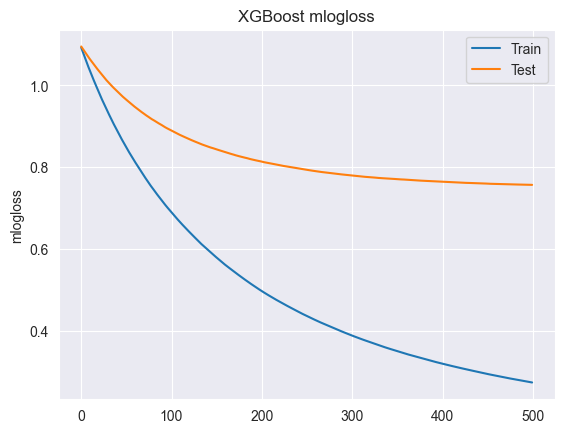

In [65]:
from matplotlib import pyplot

results = xgb_model.evals_result()
rounds = len(results['validation_0']['mlogloss'])
x_axis = range(0, rounds)

ig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('mlogloss')
pyplot.title('XGBoost mlogloss')
pyplot.show()

In [105]:
X_train_xgb_selected = X_train[selected_features['xgb']]
X_test_xgb_selected = X_test[selected_features['xgb']]

xgb_best_params = {'n_estimators': 550,
 'max_depth': 13,
 'learning_rate': 0.011643988543873496,
 'subsample': 0.896160297187044,
 'colsample_bytree': 0.5711055123610626,
 'gamma': 0.0032704911843857987,
 'reg_alpha': 1.51887480560909,
 'reg_lambda': 1.4634145004222794,
 'min_child_weight': 4}
optimized_results = learn_models(
    models={
        'XGBoost': xgb.XGBClassifier(**xgb_best_params),
    },
    dfs={
        'XGBoost': [X_train_xgb_selected, X_test_xgb_selected, y_train, y_test],
    },
    folder='optimized_train_classification',
    regression=False
)
optimized_results

Training XGBoost...
XGBoost (Classification): Accuracy = 0.6654074473826228, Precision = 0.6654527747134968, Recall = 0.6654074473826228, F1-Score = [0.67351129 0.59070191 0.71070336]


,model,Accuracy,Precision,Recall,F1-Score
0,XGBoost,0.665407,0.665453,0.665407,"[0.6735112936344969, 0.5907019143117593, 0.710703363914373]"


In [31]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Define SVM model with selected hyperparameters
svm_model = SVC(kernel='rbf', C=10, gamma=0.12773478, shrinking=True, tol=1e-4, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

accuracy, precision, recall, f1


(0.5515380464112251,
 0.6450516513300563,
 0.48251539581186886,
 0.47662547260350063)

In [74]:
import joblib

# Load the model
model = joblib.load("models/optimized_train_classification/CatBoost.joblib")

In [82]:
model.predict(X_test_cb_selected).ravel()

array([0, 1, 1, ..., 0, 1, 2])

In [88]:
cb_test_df = pd.concat([
    X_test_cb_selected,
    pd.DataFrame({'prediction': model.predict(X_test_cb_selected).squeeze()}),
    pd.DataFrame({'label': y_test})
], axis=1)

In [102]:
cb_test_df['anchor_year'].unique()

array([2112, 2172, 2178, 2114, 2134, 2171, 2184, 2142, 2115, 2162, 2186,
       2185, 2128, 2187, 2155, 2124, 2175, 2136, 2170, 2122, 2189, 2137,
       2119, 2156, 2132, 2149, 2160, 2161, 2174, 2147, 2153, 2140, 2129,
       2127, 2110, 2152, 2158, 2123, 2173, 2180, 2183, 2141, 2182, 2144,
       2176, 2150, 2143, 2130, 2116, 2138, 2167, 2118, 2146, 2168, 2159,
       2139, 2120, 2192, 2126, 2154, 2188, 2169, 2177, 2148, 2113, 2157,
       2145, 2165, 2131, 2196, 2125, 2111, 2179, 2163, 2121, 2135, 2181,
       2133, 2166, 2164, 2117, 2193, 2191, 2151, 2204, 2190, 2194, 2198,
       2199])

In [100]:
# Get predictions
predictions = pd.DataFrame({'prediction': model.predict(X_test_cb_selected).squeeze()})

# Reset index to avoid mismatches
X_test_reset = X_test_cb_selected.reset_index(drop=True)
predictions_reset = predictions.reset_index(drop=True)
y_test_reset = pd.DataFrame({'label': y_test}).reset_index(drop=True)

# Concatenate with aligned indices
cb_test_df = pd.concat([X_test_reset, predictions_reset, y_test_reset], axis=1)

# Check unique values
print(cb_test_df['prediction'].unique())


[0 1 2]


In [104]:
accuracy_by_year = (
    cb_test_df
    .groupby('anchor_year')
    .apply(lambda df: pd.Series({
        'accuracy': accuracy_score(df['label'], df['prediction']),
        'count': len(df)  # Count of samples per anchor_year
    }))
)

# Convert to DataFrame for better readability
accuracy_by_year = accuracy_by_year.reset_index().rename(columns={0: 'accuracy'})

# Display the accuracy per anchor_year
print(accuracy_by_year)

    anchor_year  accuracy     count
0          2110  0.600000 10.000000
1          2111  0.545455 22.000000
2          2112  0.727273 22.000000
3          2113  0.636364 22.000000
4          2114  0.500000 28.000000
5          2115  0.521739 23.000000
6          2116  0.650000 20.000000
7          2117  0.416667 24.000000
8          2118  0.629630 27.000000
9          2119  0.526316 19.000000
10         2120  0.800000 25.000000
11         2121  0.520000 25.000000
12         2122  0.714286 21.000000
13         2123  0.652174 23.000000
14         2124  0.681818 22.000000
15         2125  0.846154 13.000000
16         2126  0.666667 30.000000
17         2127  0.333333 12.000000
18         2128  0.695652 23.000000
19         2129  0.782609 23.000000
20         2130  0.666667 21.000000
21         2131  0.600000 25.000000
22         2132  0.714286 21.000000
23         2133  0.625000 16.000000
24         2134  0.625000 16.000000
25         2135  0.750000 32.000000
26         2136  0.862069 29

In [108]:
import joblib
from sklearn.inspection import permutation_importance

# Load the model
model = joblib.load("models/optimized_train_classification/KNN.joblib")

result = permutation_importance(model, X_test_selected_knn, y_test, scoring="accuracy", n_repeats=10, random_state=42)
feature_importance = pd.Series(result.importances_mean, index=selected_features['knn'])

In [110]:
feature_importance.sort_values(ascending=False)

ph_max_value                                         0.145332
bicarbonate_max_value                                0.089477
free_calcium_min_value                               0.030167
calcium_total_max_value                              0.023044
last_careunit_2                                      0.019806
first_careunit_2                                     0.019806
ph_was_abnormal                                      0.019482
sodium_was_abnormal                                  0.017431
first_careunit_3                                     0.017107
last_careunit_3                                      0.017107
last_careunit_1                                      0.017107
first_careunit_1                                     0.017107
hematocrit_was_abnormal                              0.016945
po2_ratio_abnormal                                   0.015920
hemoglobin_was_abnormal                              0.015866
white_blood_cells_was_abnormal                       0.014895
magnesiu

In [69]:
from ml_utils import FeatureExtractor
fe = FeatureExtractor(selected_features['rf'])
fe.extract_feature_importance('optimized_train_classification', 'Random Forest').head(20)

ph_max_value                  0.023874
sodium_max_value              0.023044
white_blood_cells_max_value   0.022770
magnesium_avg_value           0.020579
sodium_avg_value              0.020085
glucose_max_value             0.019632
glucose_avg_value             0.019605
ptt_min_value                 0.019517
ph_avg_value                  0.019408
ptt_avg_value                 0.019271
ptt_max_value                 0.019218
magnesium_max_value           0.019020
white_blood_cells_avg_value   0.018662
white_blood_cells_min_value   0.018439
calcium_total_max_value       0.018411
calcium_total_avg_value       0.018373
bicarbonate_avg_value         0.018132
ph_min_value                  0.018095
potassium_avg_value           0.017953
creatinine_avg_value          0.017913
dtype: float64

In [71]:
from ml_utils import FeatureExtractor
fe = FeatureExtractor(selected_features['xgb'])
fe.extract_feature_importance('optimized_train_classification', 'XGBoost').head(20)

first_careunit_3                      0.025454
first_careunit_2                      0.024924
first_careunit_1                      0.023888
ph_max_value                          0.022380
ph_was_abnormal                       0.019975
sodium_was_abnormal                   0.018450
magnesium_max_value                   0.016502
calcium_total_was_abnormal            0.015417
free_calcium_max_value                0.014520
first_careunit_0                      0.013587
sodium_max_value                      0.012127
discharge_location_3                  0.010872
ph_avg_value                          0.010625
glucose_csf_min_value                 0.009835
glucose_csf_avg_value                 0.009278
race_HISPANIC/LATINO - PUERTO RICAN   0.009067
po2_max_value                         0.008496
race_ASIAN                            0.008278
ph_min_value                          0.008211
lactate_ratio_abnormal                0.007895
dtype: float32

In [72]:
from ml_utils import FeatureExtractor
fe = FeatureExtractor(selected_features['cb'])
fe.extract_feature_importance('optimized_train_classification', 'CatBoost').head(20)

first_careunit_3              2.607064
white_blood_cells_max_value   2.320829
anchor_year                   2.298175
calcium_total_max_value       2.209128
ptt_min_value                 2.137359
first_careunit_1              2.100987
magnesium_avg_value           2.031858
white_blood_cells_min_value   2.023252
sodium_avg_value              1.838454
potassium_avg_value           1.818078
first_careunit_2              1.815741
ptt_avg_value                 1.783433
bicarbonate_avg_value         1.760768
calcium_total_avg_value       1.701849
sodium_ratio_abnormal         1.628109
sodium_max_value              1.614426
alt_max_value                 1.575446
magnesium_max_value           1.573814
ptt_ratio_abnormal            1.557572
pt_max_value                  1.542485
dtype: float64